##### The objective of the study is to classify type of well log zones

# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import missingno as msno
import rfpimp
import shap

# Feature scaling/ Data standardization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Model building
from sklearn import svm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from datetime import datetime, timedelta
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import re
from scipy import stats
from scipy.stats import randint, norm
from scipy.cluster.vq import whiten
import statsmodels.api as sm 
import pylab as py

# scikit-learn modules and tools
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import mean_squared_error as MSE, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

# Important global variables
SEED = 10 # guarantees reproducibility of results
kFold = 10 # 10-fold cross validation for our classifier
tune_random_forest = 'tuned_gini'  # available_options: {'grid', 'random', 'tuned_gini', 'tuned_entropy', 'untuned'}

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [46]:
# Functions
def missing_data_check(df):
    """ Check Missing Data """

    msno_count = df.apply(lambda x: x.isna().sum())
    msno_matrix = msno.matrix(df)

    print(msno_count, msno_matrix)


def outlier_boxplot(df):
    
    data0 = df.copy()
#     data0.drop(labels=['Well String Name', 'Status', 'Well Uptime'], axis=1, inplace= True)
    data_var = list(data0.columns)
    print(data_var)
#     data_var.remove('timestamp')
    df = data0[data_var]
    figure, axes= plt.subplots(df.shape[1],1, figsize=(16,len(data_var)*2))
    figure.subplots_adjust(hspace=1)
    for i,el in enumerate(df.columns):
        data.boxplot(el, widths = 0.5, patch_artist=True, ax=axes.flatten()[i], vert=0)
    plt.tight_layout()
    plt.style.use('seaborn-whitegrid')
    plt.close()
    
    return figure


def outlier_treatment(df):
    """ Remove Outlier """
    
    num = ['DEPT', 'GR_ARC', 'P28H_UNC', 'RHOB', 'TNPH']
    cols = num  # df.columns
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df


def hist_plot(df):
    """ Histogram Plot """
    
    data0 = df.copy()
#     data0.drop(labels=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans',
#                        'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
#                        'NumberOfDependents'], axis=1, inplace= True)
    data_var = list(data0.columns)
    df = data[data_var]
  
    figure, axes = plt.subplots(df.shape[1], 1, figsize=(16,len(data_var)*2))
    figure.subplots_adjust(hspace=1)
    for i, n in enumerate(df.columns):
        sns.histplot(data = data0[n], ax=axes.flatten()[i])  # widths = 0.5, patch_artist=True, vert=0
    plt.tight_layout()
    plt.style.use('seaborn-whitegrid')
    plt.close()
  
    return figure


def target_barplot(df):
    #Ploting barplot for target 
    plt.figure(figsize=(10, 6))
    g = sns.barplot(df['kmeans'], df['kmeans'], palette='Set1', estimator=lambda x: len(x) / len(df) )

    #Anotating the graph
    for p in g.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            g.text(x+width/2, 
                   y+height, 
                   '{:.0%}'.format(height), 
                   horizontalalignment='center',fontsize=15)

    #Setting the labels
    plt.xlabel('kmeans', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.title('Percentage of clusters', fontsize=16)


def distribution_plot(df, vrbl):
    """ Normality Check """
    
    x = df[vrbl].dropna(inplace=False)
    fig = plt.figure(figsize=(12, 6))
  
    axes0 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
    x.plot.kde(ax=axes0, legend=False, color='#00B1A9', label='', lw=0.7)
    x.plot.hist(density=True, ax=axes0, color='#00B1A9', alpha=0.3, ec='k', lw=0.3, label='')
#     axes0.axvline(x=x.mean(), lw=1.5, ls=':', color='#B22222')
#     axes0.axvline(x=x.median(), lw=1, ls='--', color='#764098')

    axes1 = plt.subplot2grid((3, 2), (2, 0), sharex=axes0)
    lw_value = 0.5
    axes1.boxplot(x=x, vert=False, whis=1.5, widths=0.7, showmeans=True, boxprops=dict(linewidth=lw_value),
                  flierprops=dict(marker='o', markeredgewidth=0.3, markersize=1, linewidth=lw_value), 
                  meanprops=dict(marker='*', markeredgewidth=0.3, markeredgecolor='black', markerfacecolor='#B22222'),
                  medianprops=dict(linestyle='--', linewidth=1, color='#764098'),
                  whiskerprops=dict(linestyle='-', linewidth=lw_value), capprops=dict(linestyle='-', linewidth=lw_value),
                  patch_artist=True)
    axes1.set_yticklabels('')
    axes1.set_ylabel('', size=6)

    axes2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
    sm.qqplot(x, dist=stats.norm, line='s', color='#00B1A9', marker='.', alpha=0.3, ax=axes2)
    axes2.set_title('QQ Plot')

    fig.suptitle(vrbl, size=9)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()


# Important Variable Analysis
def plot_linear_correlation(df):
    """ Linear Correlation Plot """ 
  
    variables = list(df.columns)
    df = df[variables].select_dtypes(float)
    df.dropna(axis=1, how='all', inplace=True)
    corr = df.corr()
    figure = corr.style.background_gradient(cmap='YlGnBu').set_precision(2)

    return figure


def plot_dependency_matrix(df):
    """ Dependency Plot """ 
  
    df0 = df.copy()
    variables = list(df.columns)
    df0 = df0[variables].select_dtypes(float)
    D = rfpimp.feature_dependence_matrix(df0)
    dependency = rfpimp.plot_dependence_heatmap(D, figsize=(11,10), color_threshold = 0.6)
  
    return dependency


# Splitting dataset into train and test.
def split_data(df):
    
    X = df.drop('kmeans', axis=1)
    y = df['kmeans']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=123)
    
    # Stratified
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y)

    return X_train, X_test, y_train, y_test


# Modelling
def logistic_regression(X_train, X_test, y_train, y_test):

    # Scaling
    scaler = MinMaxScaler()  # StandardScaler(), RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    start_time = datetime.now()
    
    # logistic regression model
    regr = LogisticRegression(solver='newton-cg', class_weight='balanced', random_state=0)
    
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    print('model score:{}.'.format(regr.score(X_test, y_test)))
    print("model Training done in {}.".format(datetime.now() - start_time))

    return y_pred, regr, scaler


# Metric
def evaluation_metrics(model, detail, y_test, y_pred, X_test):
    '''Calculate regression evaluation metric score as followed.

    1. Score
    2. Confusion Matrix

    '''

    summary_dict = {'model': [model], 'detail': [detail],
                    'accuracy_score': [accuracy_score(y_test, y_pred)],
                    'confusion_matrix': [confusion_matrix(y_test, y_pred)],                      
                    }
    training_metrics = pd.DataFrame.from_dict(summary_dict)

    return training_metrics


def plot_roc_auc(clf, fpr, tpr):
    ''' Plot receiver operating characteristic curve (ROC). The diagonal dashed
        line corresponds to a classifier that randomly guesses (ROC=0.5).
        The higher this value, the greater the accuracy of your classifier
        
        Args:
            clf: classifier
            fpr: false positive rate calculated by the "roc_curve" sklearn metric
            tpr: true positive rate calculated by the "roc_curve" sklearn metric
    '''
    roc_auc = auc(fpr, tpr)
    # plot the false positive rate on the x axis and the true positive rate on the y axis
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(fpr, tpr, label='AUC = {:0.3f}'.format(roc_auc))
    ax.legend(loc=0)
    ax.plot([0,1], [0,1], ls='--')
    ax.set_title('ROC: ' + clf.__class__.__name__)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    plt.show()
    
def plot_precision_and_recall(precision, recall, threshold):
    ''' Plot precision and recall vs threshold. These two are contradicting,
        like the bias and the variance of a classifier. However, there is
        always a point where these two intersect and that is usually the
        optimal threshold.
        
        Args:
            precision: precision of the classifier
            recall: recall of the classifier
            threshold: it represents the value above which
                       a data point is considered in the positive class
    '''
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(threshold, precision[:-1]*100, "r-", label="precision", linewidth=2)
    ax.plot(threshold, recall[:-1]*100, "b", label="recall", linewidth=2)
    ax.axvline(x=0.5, color='k', linestyle='dashed', label='default=0.5')
    intersect_ind = np.argwhere(np.diff(np.sign(precision[:-1] - recall[:-1]))).flatten()[0]
    ax.axvline(x=threshold[intersect_ind], color='g', linestyle='dashed', label='optimal={:.2f}'.format(threshold[intersect_ind]))
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Threshold")
    ax.legend(loc="upper right")
    ax.set_ylim([0, 100])
    plt.show()

Loading the data

In [4]:
file_name = 'well_log_cluster.csv'
data = pd.read_csv(file_name)
data.head()

,Unnamed: 0,DEPT,GR_ARC,P28H_UNC,RHOB,TNPH,kmeans
0,8545,1527.35,71.69,1.49,1.99,0.33,3
1,8546,1527.51,73.78,1.75,2.18,0.36,1
2,8547,1527.66,77.02,1.57,2.37,0.37,1
3,8548,1527.81,76.34,1.49,2.39,0.34,1
4,8549,1527.96,78.09,1.40,2.39,0.33,1


Drop unnecessary columns

In [5]:
data = data.drop(columns="Unnamed: 0", axis=1)

Inspect data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DEPT      2605 non-null   float64
 1   GR_ARC    2605 non-null   float64
 2   P28H_UNC  2605 non-null   float64
 3   RHOB      2605 non-null   float64
 4   TNPH      2605 non-null   float64
 5   kmeans    2605 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 122.2 KB


In [7]:
data.shape

(2605, 6)

In [8]:
data.columns

Index(['DEPT', 'GR_ARC', 'P28H_UNC', 'RHOB', 'TNPH', 'kmeans'], dtype='object')

In [9]:
data.nunique()

DEPT        2605
GR_ARC      1664
P28H_UNC     238
RHOB          44
TNPH          25
kmeans         4
dtype: int64

In [10]:
df_uniques = data.nunique()

In [11]:
category_variables = list(df_uniques[df_uniques == 4].index)
category_variables

['kmeans']

In [12]:
# categorical_variables = list(df_uniques[(df_uniques > 2) & (df_uniques <= 6)].index)
# categorical_variables

In [13]:
# [[i, list(data[i].unique())] for i in categorical_variables]

Brief on data check:
- There are 6 columns of features, 1 target column (kmeans) and 2605 rows of observation

In [14]:
num_features = ['DEPT', 'GR_ARC', 'P28H_UNC', 'RHOB', 'TNPH']
char_features = ['kmeans']

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
DEPT,2605.0,1740.259862,130.406979,1527.35,1631.75,1733.25,1832.76,2001.01
GR_ARC,2605.0,55.500399,19.321058,12.50,40.64,54.16,71.96,99.88
P28H_UNC,2605.0,1.600971,0.514181,0.40,1.21,1.49,1.99,2.98
RHOB,2605.0,2.445125,0.074403,1.99,2.42,2.46,2.50,2.64
TNPH,2605.0,0.266088,0.052861,0.14,0.22,0.26,0.31,0.39
kmeans,2605.0,1.135893,0.972726,0.00,0.00,1.00,2.00,3.00


# Data Checking, Cleaning, & Transformation

## Missing value treatment

Before missing value treatment

DEPT        0
GR_ARC      0
P28H_UNC    0
RHOB        0
TNPH        0
kmeans      0
dtype: int64 AxesSubplot(0.125,0.125;0.698618x0.755)


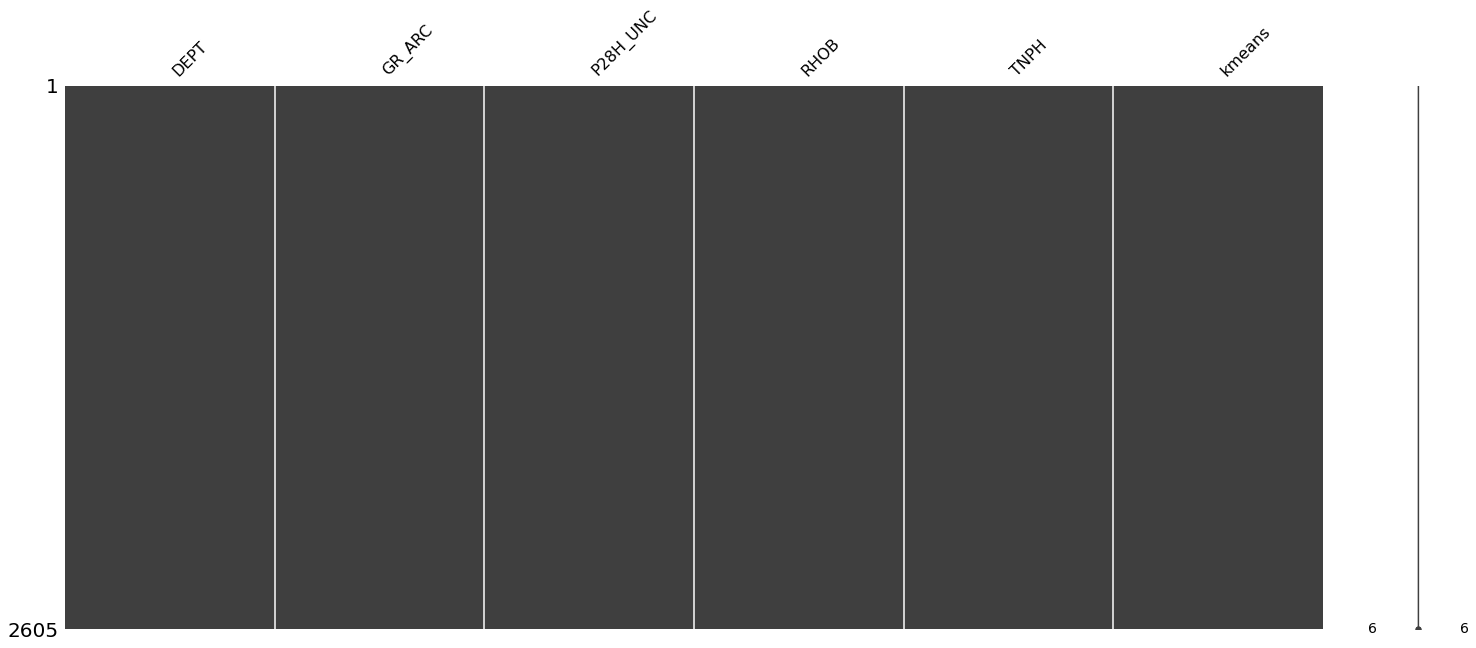

In [16]:
missing_data_check(data)

In [17]:
data = data.dropna()

After missing value treatment

DEPT        0
GR_ARC      0
P28H_UNC    0
RHOB        0
TNPH        0
kmeans      0
dtype: int64 AxesSubplot(0.125,0.125;0.698618x0.755)


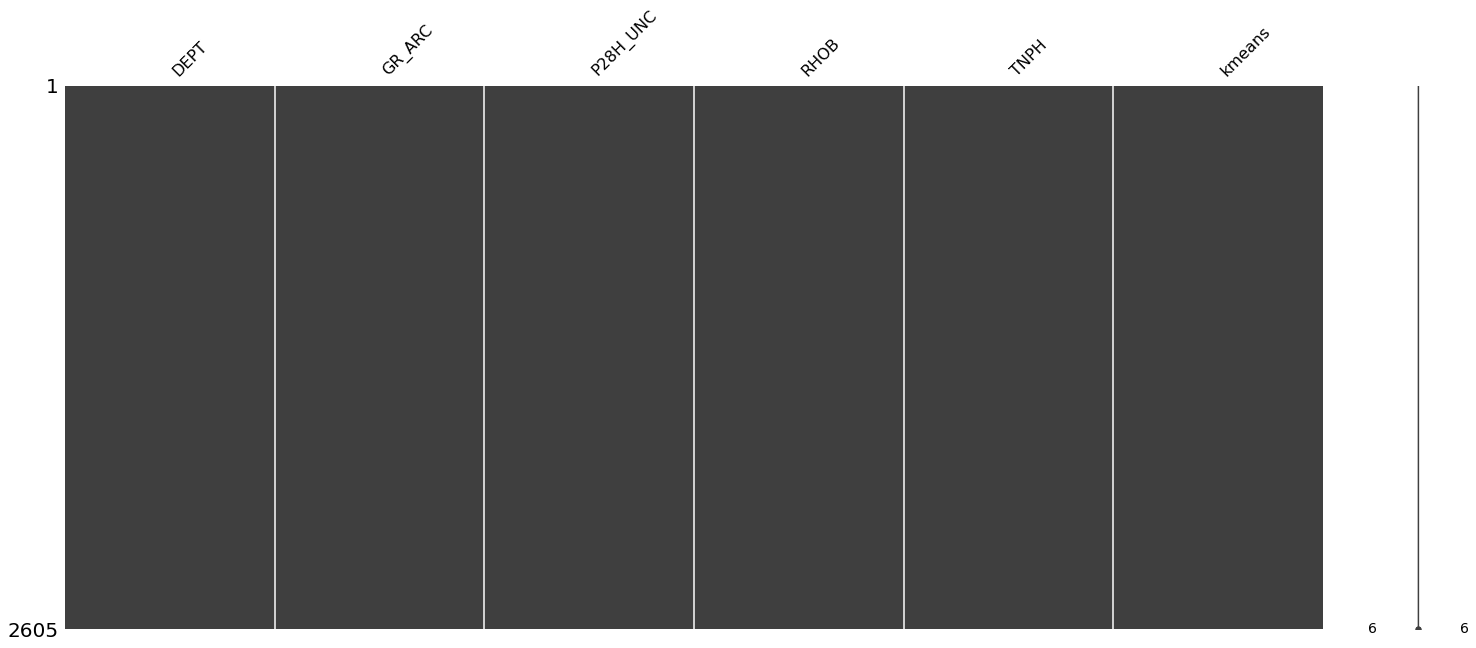

In [18]:
missing_data_check(data)

## Outlier treatment

In [19]:
box_plot_list = ['DEPT', 'GR_ARC', 'P28H_UNC', 'RHOB', 'TNPH']

Before outlier treatment. Visualize numerical features.

<AxesSubplot:>

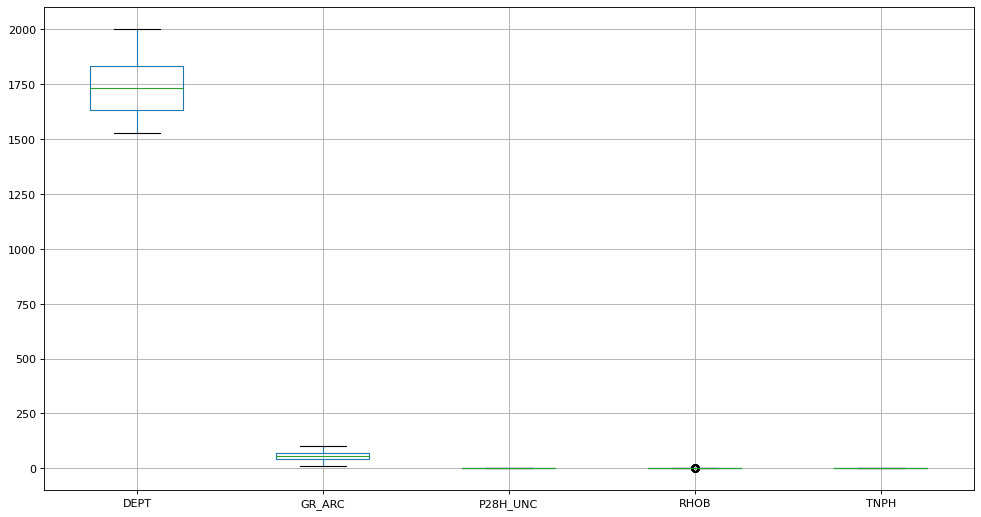

In [20]:
figure(figsize=(15, 8), dpi=80)

data.boxplot(column=box_plot_list)

In [23]:
data = outlier_treatment(data)

After outlier treatment

<AxesSubplot:>

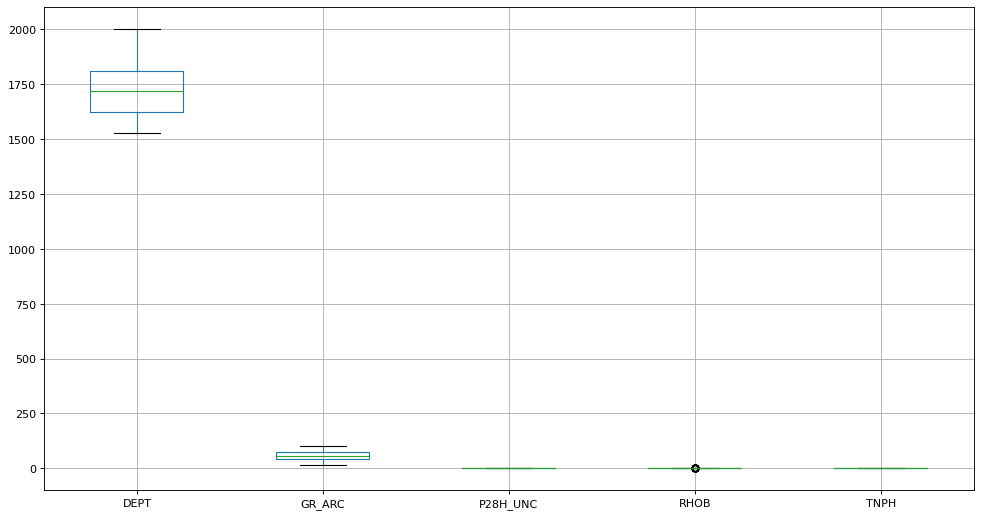

In [24]:
figure(figsize=(15, 8), dpi=80)

data.boxplot(column=box_plot_list)

# Exploratory Data Analysis

In [25]:
# sns.pairplot(data, hue='SeriousDlqin2yrs')

In [26]:
pplot_features = ['DEPT', 'GR_ARC', 'P28H_UNC', 'RHOB', 'TNPH']

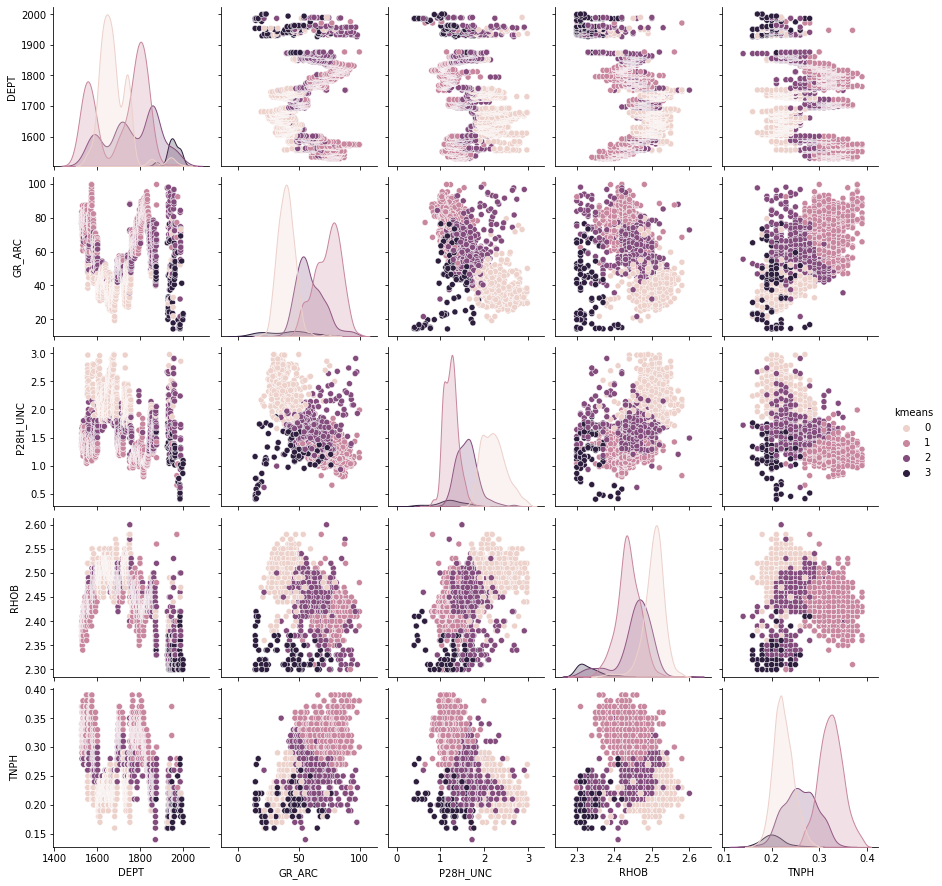

In [33]:
sns.pairplot(data, hue='kmeans')

<AxesSubplot:>

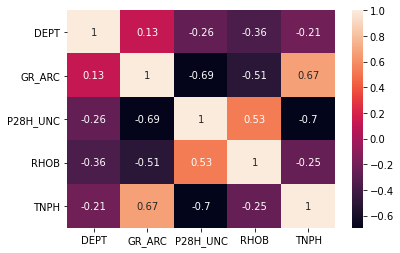

In [34]:
sns.heatmap(data[num_features].corr(), annot=True)

In [35]:
# correlations = data[input_features].corrwith(data['SeriousDlqin2yrs'])

In [36]:
# ax = correlations.plot(kind='bar')
# ax.set(ylim=[-1, 1], ylabel='pearson correlation');

In [37]:
# correlations.map(abs).sort_values()

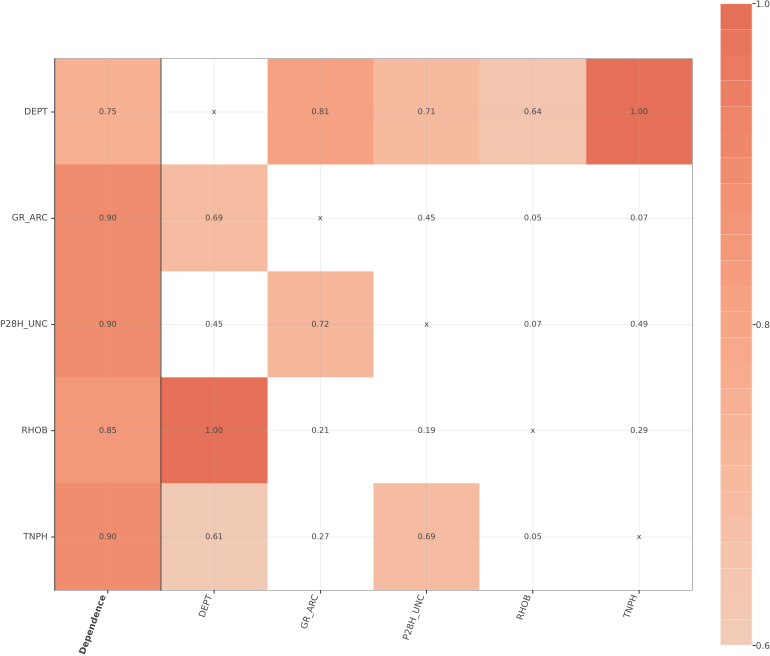

In [38]:
plot_dependency_matrix(data)

In [39]:
# Based on EDA observation:

# - There is multicollinearity problem observed in the pairplot & heatmap
# - NumberOfTimes90DaysLate is highly (positive) correlated with NumberOfTime60-89DaysPastDueNotWorse & NumberOfTime30-59DaysPastDueNotWorse

## Data Pre-process

Checking imbalance classification, features distribution, shape, skewness & kurtosis

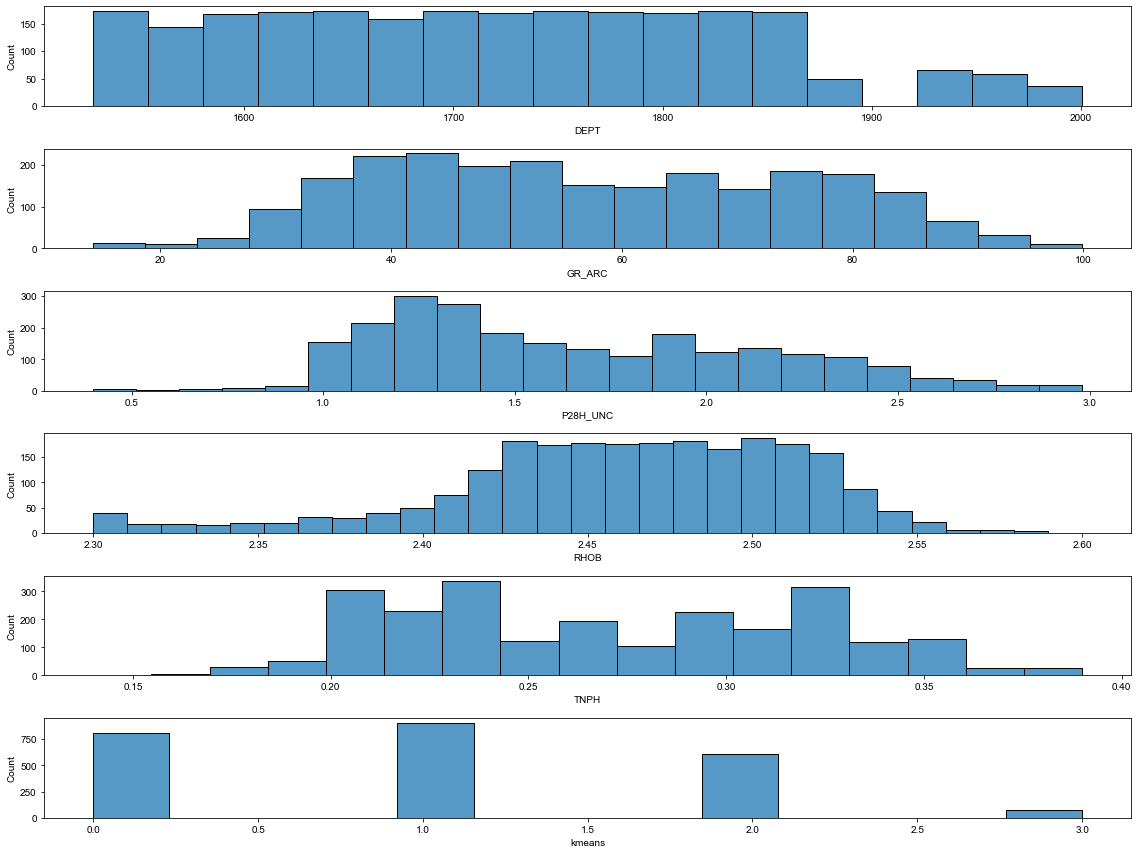

In [40]:
hist_plot(data)

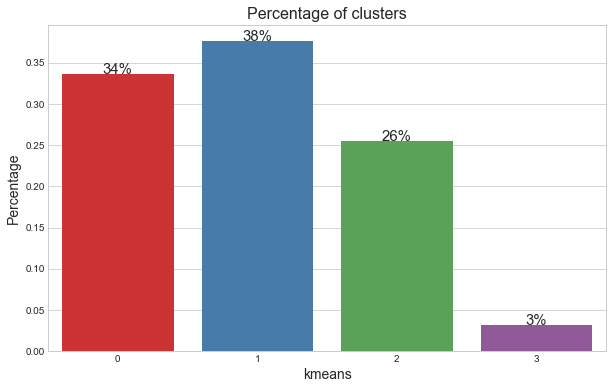

In [42]:
target_barplot(data)

0: Sandstones

1: Siltstone

2: Shale

3: Sandstone with potential hydrocarbon

From the distribution, we can see that there are only 3% of cluster 3, sandstone with potential hydrocarbon

In [43]:
pd.DataFrame.from_dict({'skewness':data[num_features].skew(), 'excess_kurtosis': data[num_features].kurt()})

,skewness,excess_kurtosis
DEPT,0.240799,-0.760929
GR_ARC,0.104059,-0.988687
P28H_UNC,0.484473,-0.662427
RHOB,-0.750002,0.656919
TNPH,0.155974,-1.130637


Based on the skewness, most numerical features are positively (moderately) skewed (0.5 - 1) & platykurtic distributions that have negative kurtosis values (distribution is flat and has thin tails).

# Modelling

## Logistic Regression

In [47]:
X_train, X_test, y_train, y_test = split_data(data)
y_pred, regr, scaler = logistic_regression(X_train, X_test, y_train, y_test)
# save_model(regr, scaler, "Exp.pkl")
evaluation_metrics('Logistic Regression', 'kmeans', y_test, y_pred, X_test)

model score:0.9625779625779626.
model Training done in 0:00:00.033912.


,model,detail,accuracy_score,confusion_matrix
0,Logistic Regression,kmeans,0.962578,"[[169, 0, 2, 0], [0, 170, 1, 0], [8, 2, 107, 5..."


##### Check for overfitting

In [48]:
model = LogisticRegression(solver='newton-cg', class_weight='balanced', random_state=0).fit(X_train, y_train)
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_score = accuracy_score(y_train, train_predict)
test_score = accuracy_score(y_test, test_predict)
matrix = confusion_matrix(y_test, test_predict)

print(matrix)
print('Train accuracy is',train_score )
print('Test accuracy is',test_score )

[[165   0   6   0]
 [  0 144  25   2]
 [ 10  11  97   4]
 [  0   0   0  17]]
Train accuracy is 0.905257678292556
Test accuracy is 0.8794178794178794


In [49]:
feature_names = data.drop(['kmeans'], axis=1).columns

Text(0.5, 76.5, 'Prediction')

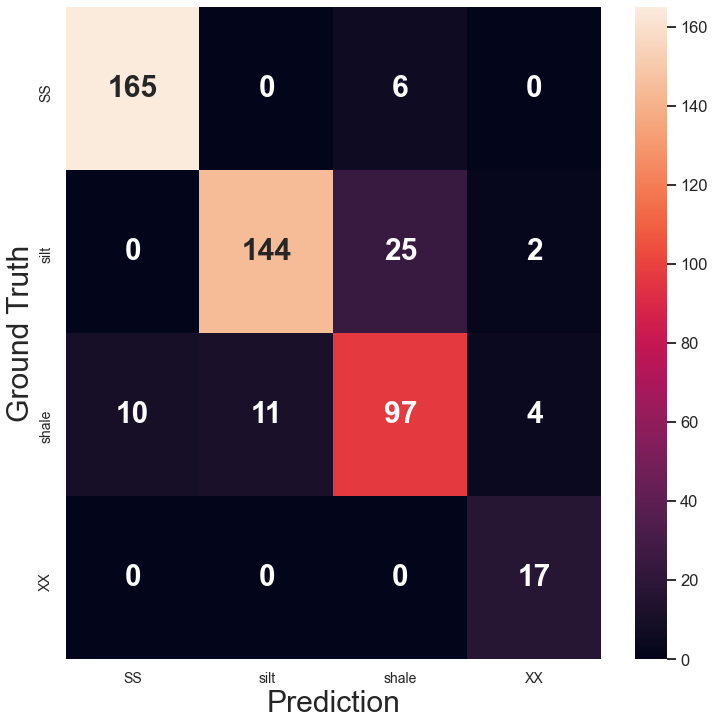

In [111]:
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, test_predict), annot=True, fmt='d', annot_kws={"size": 30, "weight": "bold"})
labels = ['SS', 'silt', 'shale', 'XX']
ax.set_xticklabels(labels, fontsize=14);
ax.set_yticklabels(labels, fontsize=14);
ax.set_ylabel('Ground Truth', fontsize=30);
ax.set_xlabel('Prediction', fontsize=30)

## K-Nearest Neighbor

In [52]:
knn = KNeighborsClassifier(n_neighbors=2)
knn = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
print('Accuracy score', round(accuracy_score(y_test, y_pred_knn), 2))
# print('F1 Score', round(f1_score(y_test, y_pred_knn), 2))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       171
           1       0.89      0.96      0.93       171
           2       0.89      0.69      0.78       122
           3       0.79      0.65      0.71        17

    accuracy                           0.89       481
   macro avg       0.87      0.82      0.84       481
weighted avg       0.89      0.89      0.88       481

Accuracy score 0.89


Text(0.5, 91.5, 'Prediction')

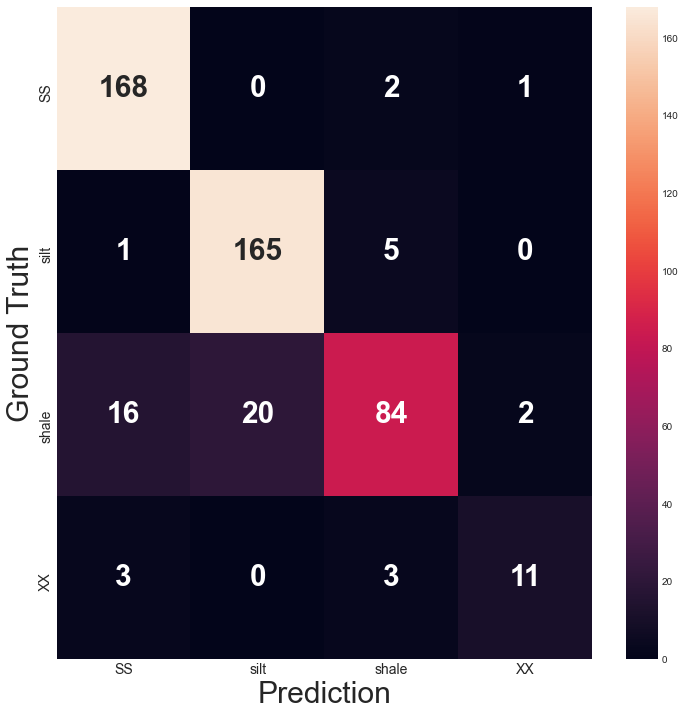

In [54]:
# confusion matrix
# sns.set_palette(sns.color_palette(colors)) 
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', annot_kws={"size": 30, "weight": "bold"})
labels = ['SS', 'silt', 'shale', 'XX']
ax.set_xticklabels(labels, fontsize=14);
ax.set_yticklabels(labels, fontsize=14);
ax.set_ylabel('Ground Truth', fontsize=30);
ax.set_xlabel('Prediction', fontsize=30)

## Support Vector Machine

In [57]:
X = data[['DEPT', 'GR_ARC', 'P28H_UNC', 'RHOB', 'TNPH']]

In [58]:
y = data['kmeans']

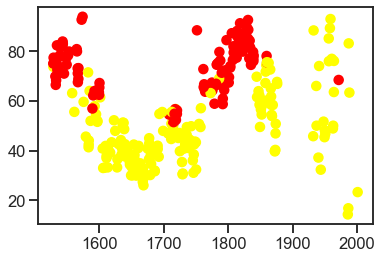

In [59]:
LSVC = LinearSVC()
LSVC.fit(X, y)

X_color = X.sample(300, random_state=45)
y_color = y.loc[X_color.index]
y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
ax = plt.axes()
ax.scatter(X_color.iloc[:, 0], X_color.iloc[:, 1], color=y_color, alpha=1)

## Bagging

In [75]:
target = 'kmeans'
data[target].value_counts()

1    905
0    807
2    613
3     77
Name: kmeans, dtype: int64

In [76]:
data[target].value_counts(normalize=True)

1    0.376769
0    0.335970
2    0.255204
3    0.032057
Name: kmeans, dtype: float64

In [77]:
y_train.value_counts(normalize=True)

0    0.50
2    0.25
1    0.25
Name: kmeans, dtype: float64

In [78]:
y_test.value_counts(normalize=True)

1    1.0
Name: kmeans, dtype: float64

In [79]:
RF = RandomForestClassifier(oob_score=True,
                           random_state=42,
                           warm_start=True,
                           n_jobs=-1)

oob_list = list()

for n_trees in [10, 20, 50, 100]:
    RF.set_params(n_estimators=n_trees)
    
    RF.fit(X_train, y_train)
    
    oob_error = 1 - RF.oob_score_
    
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    
rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
10.0,0.75
20.0,0.50
50.0,0.50
100.0,0.75


[Text(0, 0.5, 'out-of-bag error')]

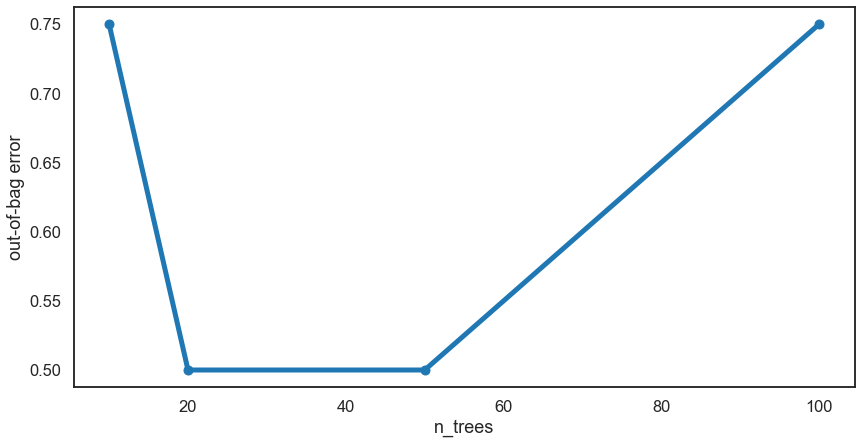

In [80]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error')

In [81]:
EF = ExtraTreesClassifier(oob_score=True,
                          random_state=42,
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

for n_trees in [10, 20, 50, 100]:
    EF.set_params(n_estimators=n_trees)
    
    EF.fit(X_train, y_train)
    
    oob_error = 1 - EF.oob_score_
    
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    
et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

,oob
n_trees,
10.0,0.75
20.0,0.75
50.0,0.75
100.0,0.75


[Text(0, 0.5, 'out-of-bag error')]

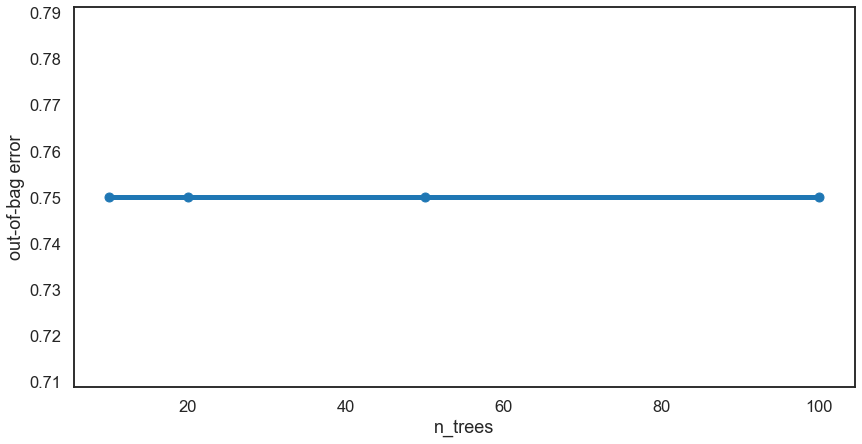

In [82]:
sns.set_context('talk')
sns.set_style('white')

ax = et_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error')

In [83]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob': 'RandomForest'}),
                   et_oob_df.rename(columns={'oob': 'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
10.0,0.75,0.75
20.0,0.50,0.75
50.0,0.50,0.75
100.0,0.75,0.75


[Text(0, 0.5, 'out-of-bag error')]

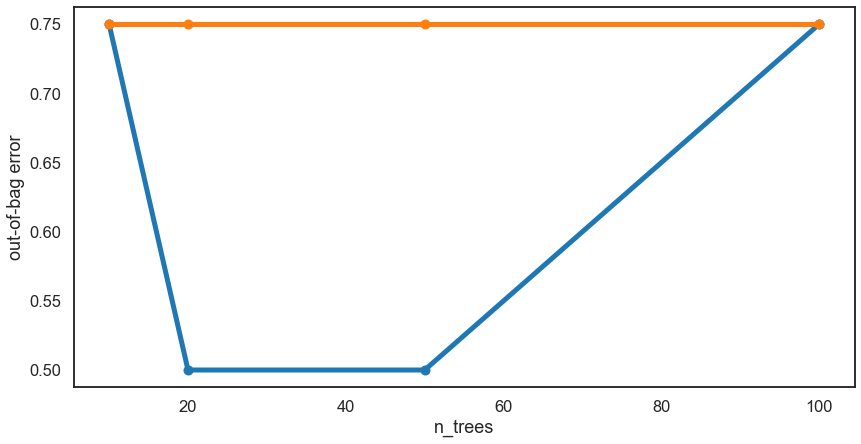

In [84]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error')

In [85]:
model = EF.set_params(n_estimators=50)

y_pred = model.predict(X_test)

y_prob = model.predict_proba(X_test)

In [86]:
y_prob

array([[0.37, 0.45, 0.18]])

[Text(0.5, 0, 'Recall'),
 Text(0, 0.5, 'Precision'),
 (-0.01, 1.01),
 (-0.01, 1.01),
 Text(0.5, 1.0, 'Precision-Recall curve')]

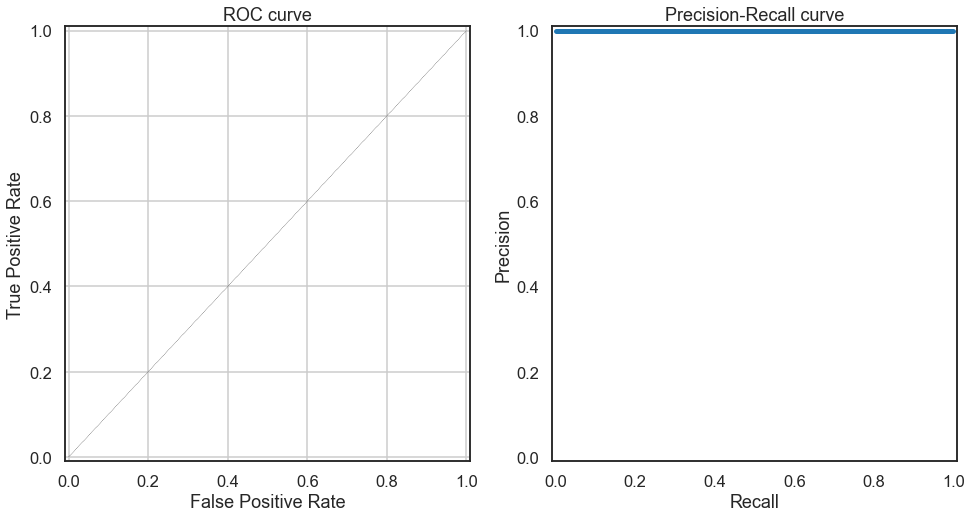

In [89]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)

ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
      ylabel='True Positive Rate',
      xlim=[-.01, 1.01], ylim=[-.01, 1.01],
      title='ROC curve')
ax.grid(True)

ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
      xlim=[-.01, 1.01], ylim=[-.01, 1.01],
      title='Precision-Recall curve')

## Boosting

In [91]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4, 5) (1, 5) (4,) (1,)


In [92]:
error_list = list()

tree_list = [10, 20, 50, 100]
for n_trees in tree_list:
    
    GBC = GradientBoostingClassifier(max_features=5, n_estimators=n_trees, random_state=42)
    
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)
    
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))
    
error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 10 trees
Fitting model with 20 trees
Fitting model with 50 trees
Fitting model with 100 trees


,error
n_trees,
10.0,0.0
20.0,0.0
50.0,0.0
100.0,0.0


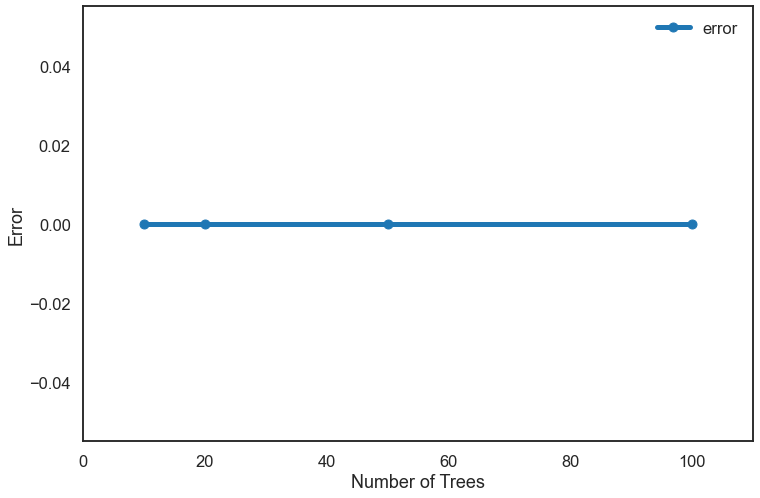

In [93]:
sns.set_context('talk')
sns.set_style('white')
# sns.set_pallete(palette)

ax = error_df.plot(marker='o', figsize=(12,8), linewidth=5)

ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

In [96]:
# CV_GBC = pickle.load(open('gv_gbc.p', 'rb'))

## Stacking

In [104]:
X_train, X_test, y_train, y_test = split_data(data)

In [105]:
LR_L2 = LogisticRegression(penalty='l2',class_weight='balanced', solver='saga', max_iter=500).fit(X_train, y_train)

In [106]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.20      0.88      0.33        40
           1       0.54      0.92      0.68       100
           2       0.82      0.47      0.60       213
           3       0.88      0.12      0.21       128

    accuracy                           0.50       481
   macro avg       0.61      0.60      0.45       481
weighted avg       0.73      0.50      0.49       481



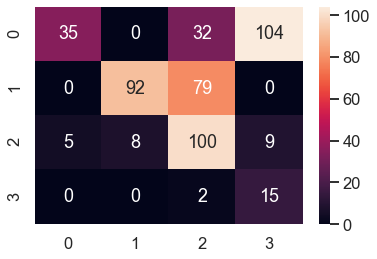

In [107]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

In [108]:
estimators = [('LR_L2', LR_L2), ('GBC', GBC)]

VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

In [109]:
y_pred = VC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       173
           1       0.99      0.99      0.99       171
           2       0.95      0.97      0.96       119
           3       1.00      0.94      0.97        18

    accuracy                           0.98       481
   macro avg       0.98      0.97      0.98       481
weighted avg       0.98      0.98      0.98       481



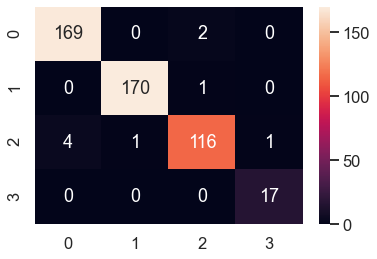

In [110]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

Text(0.5, 76.5, 'Prediction')

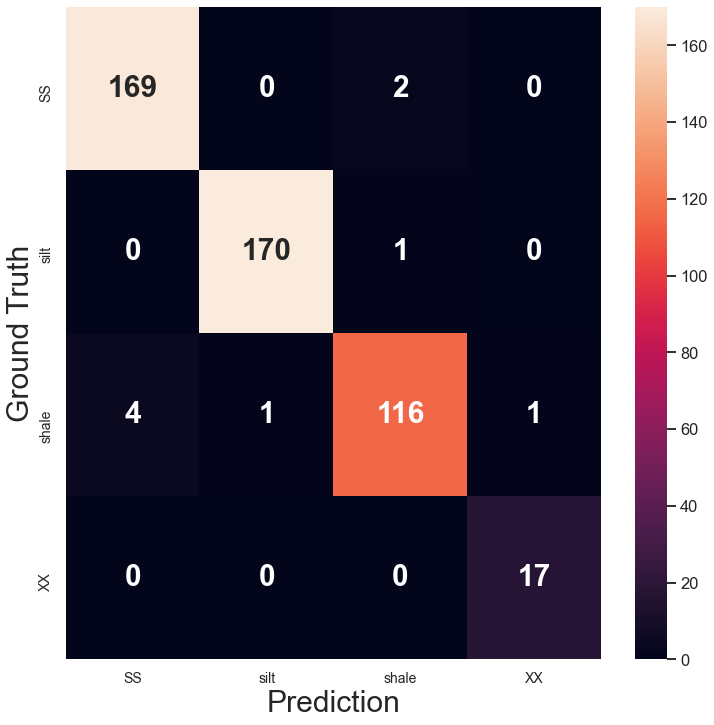

In [113]:
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 30, "weight": "bold"})
labels = ['SS', 'silt', 'shale', 'XX']
ax.set_xticklabels(labels, fontsize=14);
ax.set_yticklabels(labels, fontsize=14);
ax.set_ylabel('Ground Truth', fontsize=30);
ax.set_xlabel('Prediction', fontsize=30)

In [112]:
evaluation_metrics('Stacking', 'Stacked', y_test, y_pred, X_test)

,model,detail,accuracy_score,confusion_matrix
0,Stacking,Stacked,0.981289,"[[169, 0, 2, 0], [0, 170, 1, 0], [4, 1, 116, 1..."


In [120]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

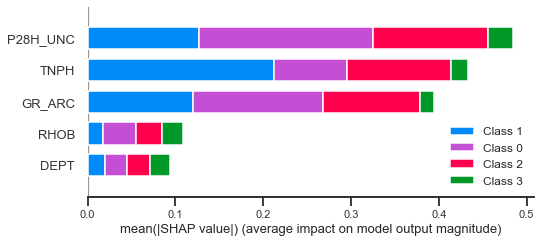

In [121]:
# print shap values of features (another metric for importance)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_df)
fig, ax = plt.subplots(figsize=(3, 3))
shap.summary_plot(shap_values, X_test_df, plot_type="bar", auto_size_plot=False)

# Summary

- In summary, logistic regression model perform better compared to the others in this case due to consideration of regularization & balancing the class weight.

- It is a good model with 0.98 metric score.

- In term of interpretation, it is confirmed that deep res, neutron, & gamma ray log are among the top features to determine NPL.